### **IMAGEN PROCESSING**

Import libraries

In [1]:
import os
#from PIL import Image
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
import time

### **Imagen prepocessing**

In [7]:
#def load_images(path):
    #'''Funtion to load images using PIL'''
    #images = []
    #names = []
    #for file in os.listdir(path):
        #final_path = os.path.join(path, file)
        #image = Image.open(final_path)
        #images.append(image)
        #names.append(file)

    #return images, names

def load_images_opencv(path):
    '''Funtion to load images using OpenCV'''
    images = []
    names = []
    for file in os.listdir(path):
        img_path = os.path.join(path, file)
        image = cv2.imread(img_path)
        images.append(image)
        names.append(file)
    return images, names


def load_labels(path):
    '''Function to load labels'''
    labels = {}
    for file in os.listdir(path): 
        final_path = os.path.join(path, file)
        with open(final_path, 'r') as f: 
            # Parse each line as a list of floats (assuming labels are space-separated)
            label_data = [list(map(float, line.strip().split())) for line in f.readlines()]
            labels[file] = label_data
    return labels


def plot_images_with_bboxes(images, names, labels, num_images=2):
    '''Function to plot two random images with bounding boxes'''
    selected_indices = random.sample(range(len(images)), num_images)

    for idx in selected_indices:
        img = images[idx]
        img_name = names[idx]
        img_labels = labels[img_name.replace('.jpg', '.txt')]

        # Get image dimensions
        height, width, _ = img.shape

        # Plot the image
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Iterate through the labels and draw bounding boxes
        for label in img_labels:
            # Check if the label has the correct number of values
            if len(label) == 11:
                _, x1, y1, x2, y2, x3, y3, x4, y4, _ , _ = label # _ignores this position
            elif len(label) == 9:  # Handle case with 9 values
                _, x1, y1, x2, y2, x3, y3, x4, y4 = label
            else:
                print(f"Skipping label with unexpected length: {len(label)}")
                continue

            # Convert relative YOLO coordinates (0 to 1 range) to pixel coordinates
            # First box (x1, y1, x2, y2)
            x1_pixel = int(x1 * width)
            y1_pixel = int(y1 * height)
            x2_pixel = int(x2 * width)
            y2_pixel = int(y2 * height)

            # Second box (x3, y3, x4, y4)
            x3_pixel = int(x3 * width)
            y3_pixel = int(y3 * height)
            x4_pixel = int(x4 * width)
            y4_pixel = int(y4 * height)

            # Draw the first rectangle (bounding box)
            plt.gca().add_patch(plt.Rectangle((x1_pixel, y1_pixel), x2_pixel - x1_pixel, y2_pixel - y1_pixel, edgecolor='red', facecolor='none', lw=2))
            
            # Draw the second rectangle (bounding box)
            plt.gca().add_patch(plt.Rectangle((x3_pixel, y3_pixel), x4_pixel - x3_pixel, y4_pixel - y3_pixel, edgecolor='blue', facecolor='none', lw=2))
        
        plt.title(f"Image: {img_name}")
        plt.axis('off')
        plt.show()



def resize_images_and_labels(images, labels, size=(640, 640)):
    '''Function for resizing images and adjusting labels including keypoints'''
    resized_images = []
    resized_labels = {}

    for img, name in zip(images, labels.keys()):
        h, w = img.shape[:2]
        resized_img = cv2.resize(img, size)
        resized_images.append(resized_img)

        # Adjust the label coordinates to the new image size
        new_labels = []
        for label in labels[name]:
            class_id = label[0]
            x_center = label[1] * size[0] / w  # Adjust x_center
            y_center = label[2] * size[1] / h  # Adjust y_center
            box_width = label[3] * size[0] / w  # Adjust width
            box_height = label[4] * size[1] / h  # Adjust height

            # Adjust keypoints (if present)
            keypoints = []
            if len(label) > 5:
                for i in range(5, len(label), 2):  # Iterate over keypoint pairs
                    kp_x = label[i] * size[0] / w  # Adjust keypoint x
                    kp_y = label[i+1] * size[1] / h  # Adjust keypoint y
                    keypoints.extend([kp_x, kp_y])

            # Combine adjusted values
            new_label = [class_id, x_center, y_center, box_width, box_height] + keypoints
            new_labels.append(new_label)

        resized_labels[name] = new_labels

    return resized_images, resized_labels


def convert_to_grayscale(images):
    '''Function to convert images to gray scale. Fist, it checks if the image is in gray scale, if not,
    it makes the convertion'''
    grayscale_images = []
    for img in images:
        if len(img.shape) == 2:
           grayscale_images.append(img) 

        else: 
            grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            grayscale_images.append(grayscale_img)
    return grayscale_images




def normalize_images(images):
    '''Function to normalize pixel values (0 - 1).'''
    normalized_images = []
    for img in images:
        #If images are not in a numpy array, they are converted to one
        img_array = np.array(img) if not isinstance(img, np.ndarray) else img
        if np.min(img_array) == 0 and np.max(img_array) == 1:
            normalized_images.append(img_array)
        else:
            normalized_img = img_array / 255.0  
            normalized_images.append(normalized_img)
    return normalized_images



#def create_dir_if_not_exists(path):
    #'''Function to create a new directory'''
    #if not os.path.exists(path):
        #os.makedirs(path)

#def save_images_and_labels(images, names, labels, save_path_img, save_path_lbl):
    #'''Function to save processed images (normalized) in .npy format and adjusted labels'''
    
    # Creat directories if they don't exist
    #os.makedirs(save_path_img, exist_ok=True)
    #os.makedirs(save_path_lbl, exist_ok=True)
    
    #for img, name in zip(images, names):
        # Change the extesion from jpg to npy
        #img_name = name.replace('.jpg', '.npy')  
        
        # Save image in .npy
        #np.save(os.path.join(save_path_img, img_name), img)

        # Save the label
        #label_name = name.replace('.jpg', '.txt')  
        #with open(os.path.join(save_path_lbl, label_name), 'w') as f:
            #for label in labels[label_name]:
        
                #f.write(' '.join(map(str, label)) + '\n')




### Import data

In [3]:
train_images_path = r"..\1-Data\BoneFractureYolo8\train\images"
train_labels_path = r"..\1-Data\BoneFractureYolo8\train\labels"
test_images_path = r"..\1-Data\BoneFractureYolo8\test\images"
test_labels_path = r"..\1-Data\BoneFractureYolo8\test\labels"
valid_images_path = r"..\1-Data\BoneFractureYolo8\valid\images"
valid_labels_path = r"..\1-Data\BoneFractureYolo8\valid\labels"

In [4]:
#Train dataset
train_images, train_names = load_images_opencv(train_images_path)
train_labels = load_labels(train_labels_path)

#Valid dataset
valid_images, valid_names = load_images_opencv(valid_images_path)
valid_labels = load_labels(valid_labels_path)

#Test
test_images, test_names = load_images_opencv(test_images_path)
test_labels =load_labels(test_labels_path)

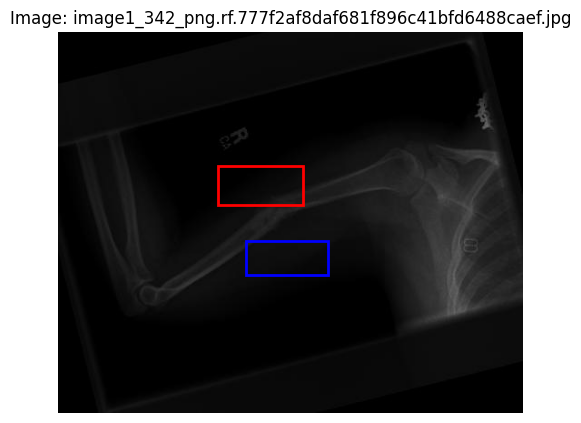

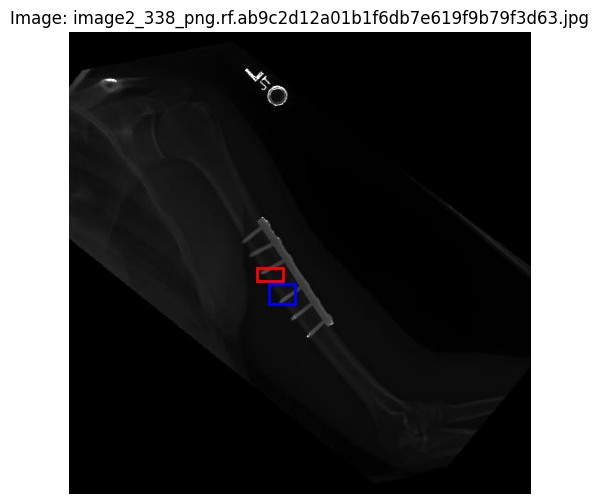

In [5]:
plot_images_with_bboxes(train_images, train_names, train_labels)

### Processing images

In [8]:
#Resizing images
train_resized_images, train_resized_labels = resize_images_and_labels(train_images, train_labels)
test_resized_images, test_resized_labels = resize_images_and_labels(test_images, test_labels)
valid_resized_images, valid_resized_labels = resize_images_and_labels(valid_images, valid_labels)

#Gray scale
train_gray_images = convert_to_grayscale(train_resized_images)
test_gray_images = convert_to_grayscale(test_resized_images)
valid_gray_images = convert_to_grayscale(valid_resized_images)

#Normalizing images
train_normalized_images = normalize_images(train_gray_images)
test_normalized_images = normalize_images(test_gray_images)
valid_normalized_images = normalize_images(valid_gray_images)

-----------

### **Train models**

In [ ]:
model_s = YOLO("yolov10s.pt")
model_m = YOLO("yolov10m.pt")
model_b = YOLO("yolov10b.pt")

In [ ]:
start_time_s = time.time()
model_s.train(data=r"..\1-Data\BoneFractureYolo8\data.yaml", epochs=10, imgsz=640, batch=16, save_period=2)
end_time_s = time.time()
elapsed_time_s = end_time_s - start_time_s
print(f"Train time for YOLOv10-S): {elapsed_time_s:.2f} seconds")

In [ ]:
model_s = YOLO('path_to_last_checkpoint.pt')  # Cargar el último checkpoint
model_s.train(data=r"..\1-Data\BoneFractureYolo8\data.yaml", epochs=100, imgsz=640, batch=16, resume=True)

In [ ]:
start_time_m = time.time()
model_m.train(data=r"..\1-Data\BoneFractureYolo8\data.yaml", epochs=100, imgsz=640, batch=16)
end_time_m = time.time()
elapsed_time_m = end_time_m - start_time_m
print(f"Train time for YOLOv10-S: {elapsed_time_m:.2f} seconds")

In [ ]:
start_time_b = time.time()
model_b.train(data=r"..\1-Data\BoneFractureYolo8\data.yaml", epochs=100, imgsz=640, batch=16)
end_time_b = time.time()
elapsed_time_b = end_time_b - start_time_b
print(f"Train time for YOLOv10-S: {elapsed_time_b:.2f} seconds")

MOdelo 2
red para detectar partes cuerpo
subred para ver si hay fractura

Modelo 1
Meter todo en yolo